# Comparison of the response spectrum calculated by dvars.dars with the data stored in the ESM-DB database


In order to verify the correctness of the response spectrum calculation, we use the seismic data archived in __[Engineering Strong-Motion Database](https://esm-db.eu)__, perform our own calculation using the python package dvars and compare the result of our calculation with the archived response spectrum.

## Data downloaded from ESM-DB archive

Using the webservice https://esm-db.eu we search and download the seismic event record

https://esm-db.eu/#/event/INT-20250227_0000079

This is a seismic event induced by mining activity near Lubin, Poland at 2025-02-27 08:20. In the database there is archived record of only one seismic station CZ.DPC Dobruška Polom.

We download both the preprocessed record in miniseed seismic format and then the archived response spectrum. Next, we will work only with the directional component N (the strongest record) and two files
- accelerogram ``./data/esmdb/CZ.DPC..HNN.INT-20250227_0000079.ACC.MP.mseed``
- pseudo-accelereation response spektrum PSA <br> ``./data/esmdb/CZ.DPC..HNN.D.INT-20250227_0000079.SA.MP.ASC``
- displacement response spektrum DRS <br> ``./data/esmdb/CZ.DPC..HNN.D.INT-20250227_0000079.DA.MP.ASC``


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from obspy import read

/home/zapa/prj/obspy/.venv/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# load accelerogram
fname="./data/esmdb/CZ.DPC..HNN.INT-20250227_0000079.ACC.MP.mseed"
st=read(fname)

In [3]:
st[0].stats

         network: CZ
         station: DPC
        location: 
         channel: HNN
       starttime: 2025-02-27T08:19:58.008399Z
         endtime: 2025-02-27T08:21:56.993399Z
   sampling_rate: 200.0
           delta: 0.005
            npts: 23798
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 24, 'encoding': 'FLOAT32', 'byteorder': '>', 'record_length': 4096, 'filesize': 98304})

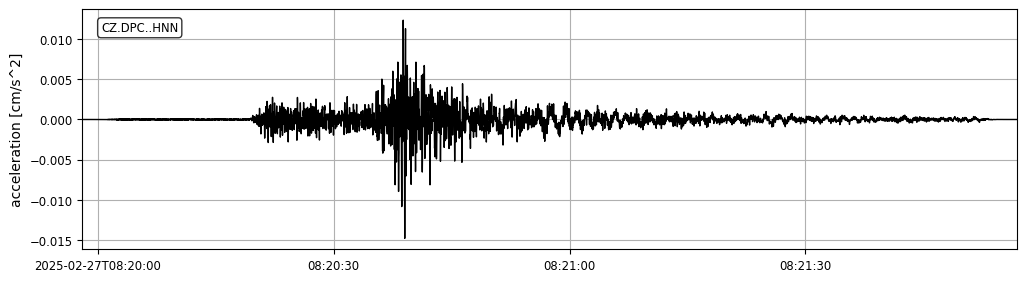

In [4]:
fig=plt.figure(figsize=(11,4))
st.plot(fig=fig)
ax=fig.axes[0]
ax.set_ylabel("acceleration [cm/s^2]")
plt.grid()
plt.show()

The accelerogram shown above is described as preprocessed in these steps:
- detrend
- filter BP 0.15 Hz - 40 Hz, Butterworth order 2
- taper
- sensitivity removal


Note: <br>
The calibration in cm/s^2 is in the obsolete CGS system of units. During the calculation, we convert it to mm/s^2 units, which are compatible with the SI system.

In [5]:
def read_esm_asc(fname):
    '''
    Read ESM-DB ASCII format of response spectrum
    Returns:
    header - format items in dictionary structure
    f - frequencies
    sa - response amplitudes
    '''
    header=dict()
    T_a=list()
    with open(fname,'r') as fi:
        for line in fi:
            if ':' in line:
                key,val = line.partition(":")[::2]
                header[key.strip()]=val.strip()            
            else:
                T_a.append([float(x) for x in line.split()])
    T,amp=list(zip(*T_a))
    f=1/np.array(T)
    sa=np.array(amp)
    return header,f,sa   
        

In [6]:
# displacement response spektrum DRS 
fname="./data/esmdb/CZ.DPC..HNN.D.INT-20250227_0000079.SD.MP.ASC"
hD,f,D=read_esm_asc(fname)

In [7]:
# read pseudo-accelereation response spektrum
fname="./data/esmdb/CZ.DPC..HNN.D.INT-20250227_0000079.SA.MP.ASC"
hA,f,A=read_esm_asc(fname)

In [8]:
# list of selected parameters stored in the header
print("Event: ",hA['EVENT_ID'])
print("Date, time: ",hA['EVENT_DATE_YYYYMMDD'],hA['EVENT_TIME_HHMMSS'])
print("Lat, lon, depth: ",hA['EVENT_LATITUDE_DEGREE'],hA['EVENT_LONGITUDE_DEGREE'],hA['EVENT_DEPTH_KM'])
print("Magnitude: ",hA['MAGNITUDE_L'])
print("Station: ",hA['NETWORK'],hA['STATION_CODE'],hA['STATION_NAME'])
print("Epi dist:",hA['EPICENTRAL_DISTANCE_KM'])
print("Stream: ",hA['STREAM'])
print(hA['DATA_TYPE'],hA['UNITS'])
print("Filter: ",hA['FILTER_TYPE'],hA['FILTER_ORDER'],hA['LOW_CUT_FREQUENCY_HZ'],hA['HIGH_CUT_FREQUENCY_HZ'])

Event:  INT-20250227_0000079
Date, time:  20250227 081957
Lat, lon, depth:  51.4991 16.0826 1.0
Magnitude:  4.0
Station:  CZ DPC Dobruska Polom
Epi dist: 128.9
Stream:  HNN
ACCELERATION RESPONSE SPECTRUM cm/s^2
Filter:  BUTTERWORTH 2 0.150 40.000


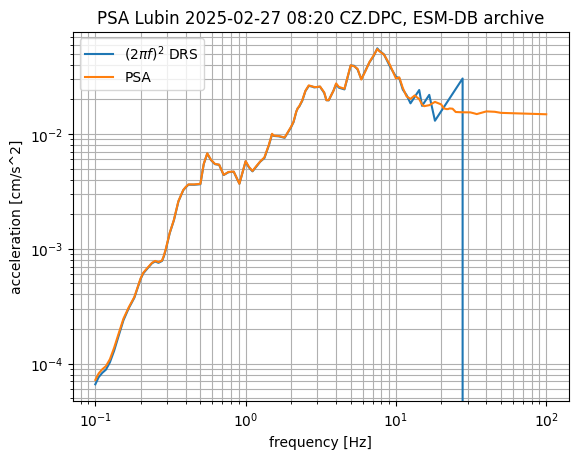

In [9]:
# plot the response spectrum downloaded from the ESM-DB archive
plt.title("PSA Lubin 2025-02-27 08:20 CZ.DPC, ESM-DB archive")
plt.loglog(f,D*(2*np.pi*f)**2, label="$(2 \pi f)^2 $ DRS")
plt.loglog(f,A, label="PSA")
plt.grid(which='both')
plt.xlabel("frequency [Hz]")
plt.ylabel("acceleration [cm/s^2]")
plt.legend()
plt.show()

From the response spectra plotted above, it can be seen that the archived spectrum is of the pseudo-acceleration response spectrum PSA type, which is calculated in a simplified way from relative displacement response spectra $$\mathrm{PSA}= (2 \pi f)^2 \mathrm{DRS}$$

The difference at frequencies higher than 10 Hz is caused by rounding of small values of DRS numbers stored in the archived text file.

## Calculating response spectrum using the dvars module

In [10]:
# import module for calculating response spectra
import dvars

Loading shared library from /home/zapa/prj/obspy/.venv/lib/python3.11/site-packages/dvars/dars/./libdars.cpython-311-x86_64-linux-gnu.so


In [11]:
# To perform the response spectrum calculation, run the dvars.dars function.
# Function arguments
help(dvars.dars)

Help on function dars in module dvars.dars.dars:

dars(data: numpy.ndarray, sampling_rate: float, nfreq=40, freq1=1.0, freq2=50.0, damp=0.05) -> (<class 'numpy.ndarray'>, <class 'numpy.ndarray'>)
    Perform the PSA analysis using a c subroutines dars and rdcalcdp from
    the shared library dars.so. 
    
    Parameters
    ----------
    damp=0.05 : float
        The harmonic oscillator damping.
    nfreq=40 : int
        The number of frequencies.
    freq1=1.0 : float
        The first frequency.
    freq2=50.0 : float
        The last frequency.
    
    Input data
    ----------
    data : np.ndarray
        The input accelerogram.
    sampling_rate : float
        The sampling rate.
    
    Returns
    -------
    freq: np.ndarray
        The frequency array.
    srd: np.ndarray
        The relative displacement response spectrum.
    saa: np.ndarray
        The absolute accelerarion response spectrum.



In [12]:
# Calculate the response spectrum
# Outputs are stored in rs
rs=dict()
for tr in st:
    # Arguments other than the default values 
    # nfreq=40, freq1=1.0 Hz, freq2=50.0 Hz
    # must be called explicitly
    #                         tr.data*10 [mm/s^2]
    freq,srd,saa = dvars.dars(tr.data*10, tr.stats.sampling_rate,
                             nfreq=105, freq1=0.1, freq2=100.0)
    rs[tr.id]=srd

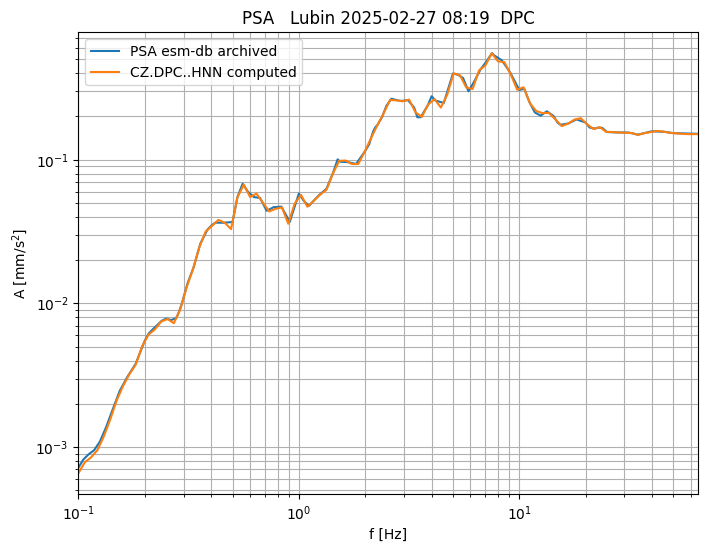

In [13]:
title="Lubin 2025-02-27 08:19"

fig = plt.figure(figsize=(8, 6), dpi=100)
chid = next(iter(rs)).split('.') # označení stanice 
sta=chid[1]
plt.title("PSA   "+title+"  "+sta)
plt.xlabel('f [Hz]')
plt.ylabel('A $\\mathrm{[mm/s^2] }$')
plt.xlim(0.1,65.0)
#plt.ylim(0.05,15)
plt.grid(which='both', axis='both')
# plot the response spectrum downloaded from the ESM-DB archive
plt.loglog(f,A*10, label="PSA esm-db archived")  # A*10 [mm/s^2]
# plot the response spectrum computed by dvars.dars from accelorogram
for id,s in rs.items():
    plt.loglog(freq,s*(2*np.pi*freq)**2,label=id+" computed")
plt.legend()
plt.show()